In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from os.path import join
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from core.DiT_model_lib import *
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
from pprint import pprint

saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [3]:
def find_all_ckpt_steps(ckptdir, verbose=True):
    ckpt_files = [f for f in os.listdir(ckptdir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    ckpt_steps = [int(f.split("_")[-1].split(".")[0]) for f in ckpt_files]
    if verbose:
        print(f"Found {len(ckpt_steps)} checkpoints in the directory, largest step is {max(ckpt_steps)}")
    return sorted(ckpt_steps)


def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def fetch_ref_img_tsr(dataset, ref_img_idx=188):
    """
    Fetch a reference image from the dataset and convert it to a tensor.
    """
    if isinstance(ref_img_idx, int):
        ref_x_raw = dataset[ref_img_idx][0] # 77 is a nice example
    # if it's a iterable, then it's a list of images
    elif isinstance(ref_img_idx, (list, tuple, range, np.ndarray)):
        ref_x_raw = ([dataset[i][0] for i in ref_img_idx])
        ref_x_raw = np.stack(ref_x_raw)
    else:
        raise ValueError(f"Invalid reference image index: {ref_img_idx}")
    ref_x_raw = torch.from_numpy(ref_x_raw).float() / 255.0
    ref_x = (ref_x_raw - 0.5) / 0.5
    return ref_x


from einops import rearrange
def patch_mean_cov(X, P, device='cuda'):
    # X = data_Xtsr[1000:3000].cpu()
    # X = (X - 0.5) / 0.5
    # Y = data_Xtsr[1000:3000].cpu()
    C_out = X.shape[1]
    C_in = X.shape[1]
    # X: (N, C_in, H, W), Y: (N, C_out, H_out, W_out)
    unfold = torch.nn.Unfold(kernel_size=P, padding=P//2, stride=1)
    X_patches = unfold(X)
    print(X_patches.shape)
    # n_samples, n_patch_elements, n_positions = X_patches.shape
    X_patches_flatten = rearrange(X_patches, "n_sample n_element n_position -> (n_sample n_position) n_element").to(device)
    patch_mean = X_patches_flatten.mean(dim=0)
    patch_cov = torch.cov(X_patches_flatten.T).to(device)  # Transpose to get n_element by n_element covariance matrix
    return patch_mean, patch_cov


def patch_Gaussian_denoiser(patch_mean, patch_cov, noise_level, P, C_in, device='cuda'):
    sigma = noise_level
    eye_mat = torch.eye(patch_cov.shape[0], device=device)
    patch_cov = patch_cov.to(device)
    patch_mean = patch_mean.to(device)
    denoiser_jacobian = patch_cov @ torch.linalg.inv(patch_cov + eye_mat * sigma ** 2)
    denoiser_bias = (eye_mat - denoiser_jacobian) @ patch_mean
    W_center = denoiser_jacobian.view(C_in, P, P, C_in, P, P)[:, P//2, P//2, :, :, :]
    b_center = denoiser_bias.view(C_in, P, P)[:, P//2, P//2]
    print(W_center.shape)
    print(b_center.shape)
    return denoiser_jacobian, denoiser_bias, W_center, b_center


def compute_patch_Gaussian_denoiser(data_Xtsr, P, noise_level, device='cuda'):
    C_in = data_Xtsr.shape[1]
    print("Computing patch mean and covariance")
    patch_mean, patch_cov = patch_mean_cov(data_Xtsr, P, device="cpu")
    print("Computing patch Gaussian denoiser")
    denoiser_jacobian, denoiser_bias, W_center, b_center = patch_Gaussian_denoiser(patch_mean, patch_cov, noise_level, P, C_in, device=device)
    return denoiser_jacobian, denoiser_bias, W_center, b_center


def build_linear_conv_denoiser_layer(patch_mean, patch_cov, noise_level, P, C_in, device='cuda'):
    print("Computing patch Gaussian denoiser")
    denoiser_jacobian, denoiser_bias, W_center, b_center = patch_Gaussian_denoiser(patch_mean, patch_cov, noise_level, P, C_in, device=device)
    conv_GaussianPatch = torch.nn.Conv2d(C_in, C_in, kernel_size=P, padding=P//2, stride=1)
    conv_GaussianPatch.weight.data = W_center
    conv_GaussianPatch.bias.data = b_center
    return conv_GaussianPatch


def compute_mean_cov_eigen(X, P, out_device="cuda", stride=1, padding=None):
    if padding is None:
        padding = P // 2
    unfold = torch.nn.Unfold(kernel_size=P, padding=padding, stride=stride)
    X_patches = unfold(X)
    print(X_patches.shape)
    X_patches_flatten = rearrange(X_patches, "n_sample n_element n_position -> (n_sample n_position) n_element").to(device)
    print(X_patches_flatten.shape)
    patch_mean = X_patches_flatten.mean(dim=0)
    patch_cov = torch.cov(X_patches_flatten.T).to(device)
    eigval, eigvec = torch.linalg.eigh(patch_cov.cuda())
    return patch_mean.to(out_device), patch_cov.to(out_device), eigval.to(out_device), eigvec.to(out_device)

In [6]:
import torch
import torch.nn as nn

class AdaptiveGaussianDenoiser(nn.Module):
    def __init__(self,
                 eigvec: torch.Tensor,     # shape (C_in*P*P, eigen_dim)
                 eigval: torch.Tensor,     # shape (eigen_dim,)
                 patch_mean: torch.Tensor,  # shape (C_in*P*P,)
                 patch_size: int):
        """
        eigvec:       eigenvectors of patch covariance, flattened rows, columns as eigen vector
        eigval:       eigenvalues of patch covariance
        patch_mean:   mean vector of each patch entry
        patch_size:   spatial size P of each patch (P x P)
        """
        super().__init__()
        device = eigvec.device
        self.register_buffer('eigval', eigval)
        self.eigen_dim = eigval.numel()
        self.P = patch_size
        
        # infer C_in and C_out from shapes
        total_entries = patch_mean.numel()
        C_in = total_entries // (self.P**2)
        C_out = C_in
        self.C_in = C_in
        self.C_out = C_out
        # 1) conv to project input patches onto eigen-basis
        self.conv_eigvec = nn.Conv2d(
            in_channels=C_in,
            out_channels=self.eigen_dim,
            kernel_size=self.P,
            padding=self.P//2,
            bias=True
        )
        # set weights = eigvec.T reshaped, bias = -eigvec.T @ patch_mean
        self.conv_eigvec.weight.data = eigvec.T.view(
            self.eigen_dim, C_in, self.P, self.P
        )
        self.conv_eigvec.bias.data = - (eigvec.T @ patch_mean)
        # freeze these parameters
        for param in (self.conv_eigvec.weight, self.conv_eigvec.bias):
            param.requires_grad_(False)

        # 2) conv to read out only the center pixel projection
        # build a mask that picks the center location in each flattened row
        center_mask = torch.zeros(C_in, self.P, self.P, dtype=torch.bool, device=device)
        center_mask[:, self.P//2, self.P//2] = True
        center_mask   = center_mask.view(-1)          # shape (C_in*P*P,)
        eigvec_center = eigvec[center_mask, :]        # (C_out, eigen_dim)
        mean_center   = patch_mean[center_mask]       # (C_out,)
        self.readout_conv = nn.Conv2d(
            in_channels=self.eigen_dim,
            out_channels=C_out,
            kernel_size=1,
            bias=True
        )
        self.readout_conv.weight.data = eigvec_center.view(
            C_out, self.eigen_dim, 1, 1
        )
        self.readout_conv.bias.data = mean_center
        for param in (self.readout_conv.weight, self.readout_conv.bias):
            param.requires_grad_(False)

    def forward(self, x: torch.Tensor, sigma_vec: torch.Tensor) -> torch.Tensor:
        """
        x:           (batch, C_in, H, W)
        sigma_vec:   (batch,) noise level for each sample
        returns:     (batch, C_out, H, W) denoised output
        """
        sigma_vec = sigma_vec.view(-1)
        # project onto eigen-space
        eigrepr = self.conv_eigvec(x)  # shape (B, eigen_dim, H, W)
        # compute per-sample shrinkage factors
        # shape (B, eigen_dim)
        shrink_factors = self.eigval[None, :] / (sigma_vec[:, None]**2 + self.eigval[None, :])
        # reshape to broadcast over spatial dims: (B, eigen_dim, 1, 1)
        shrink_factors = shrink_factors[..., None, None]
        # apply shrinkage in eigen-space
        shr_eigrepr = eigrepr * shrink_factors
        # reconstruct only center pixel outputs
        out = self.readout_conv(shr_eigrepr)  # (B, C_out, H, W)
        return out

In [8]:
import sys
from os.path import join
sys.path.append("/n/home12/binxuwang/Github/edm")
from training.dataset import TensorDataset, ImageFolderDataset
edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
dataset = ImageFolderDataset(edm_ffhq64_path)

In [9]:
Xtsr64_2000 = fetch_ref_img_tsr(dataset, range(4000))
P = 15
device = "cpu"
patch_mean, patch_cov, eigval, eigvec = compute_mean_cov_eigen(Xtsr64_2000, P, out_device="cuda", stride=4)

torch.Size([4000, 675, 256])
torch.Size([1024000, 675])


In [10]:
Xtsr = fetch_ref_img_tsr(dataset, range(70000))
Xmean = Xtsr.mean(dim=0)

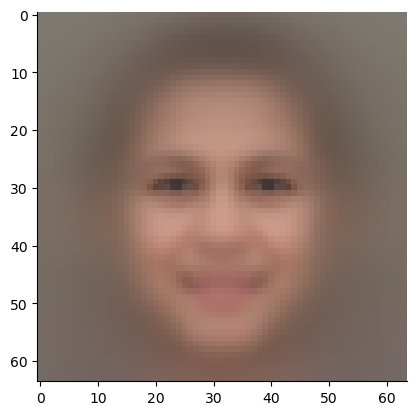

In [11]:
plt.imshow((Xmean * 0.5 +0.5).permute(1,2,0))

In [12]:
C_in = 3
conv_denoiser_bank = {}
for noise_level in [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.5, 4.5, 5.0, 7.5]:
    conv_denoiser = build_linear_conv_denoiser_layer(patch_mean, patch_cov, noise_level, P, C_in, device='cuda')
    conv_denoiser_bank[noise_level] = conv_denoiser

Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])
Computing patch Gaussian denoiser
torch.Size([3, 3, 15, 15])
torch.Size([3])


### Try to regress the UNet output to this

In [13]:
edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
# if dataset_name == "FFHQ":
edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
dataset = ImageFolderDataset(edm_ffhq64_path)
imgsize = 64
imgchannels = 3
Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
Xtsr = (Xtsr_raw * 2 - 1)
Xmean = Xtsr.mean(dim=0).cuda()

In [14]:
exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
expname = "FFHQ64_UNet_CNN_EDM_4blocks_wide128_attn_saveckpt_fewsample_longtrain"
savedir = join(saveroot, expname)
config = edict(json.load(open(f"{savedir}/config.json")))

In [44]:
unet = create_unet_model(config)
# model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd.to("cuda")

total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


EDMCNNPrecondWrapper(
  (model): SongUNet(
    (map_noise): PositionalEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (64x64_conv): Conv2d()
      (64x64_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (16x16_block0): UNetBlo

In [23]:
torch.cuda.empty_cache()

In [22]:
X_batch = Xtsr[128:256].cuda()
# 0.01, 
for noise_level in [0.05, 0.1, 0.5, 1.0, 1.5, 2.5, 4.5, 5.0, 7.5, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 70.0, 80.0]:
    sigma = torch.ones([X_batch.shape[0],] + [1, ] * (X_batch.ndim - 1), device=X_batch.device) * noise_level
    noised_sample = X_batch + torch.randn_like(X_batch) * sigma
    D_yn = model_precd(noised_sample, sigma)
    if noise_level < 10.0:
        with torch.no_grad():
            D_patchconv = conv_denoiser_bank[noise_level](noised_sample)
        loss = (D_yn - D_patchconv) ** 2
    else:
        loss = (D_yn - Xmean.expand_as(D_yn)) ** 2
    loss = loss.mean()
    print(noise_level, loss.item())
    # loss.backward()
    torch.cuda.empty_cache()

0.05 0.0009286185959354043
0.1 0.00541308056563139
0.5 0.11827193200588226
1.0 0.206814706325531
1.5 0.23782283067703247
2.5 0.2501443028450012
4.5 0.21172833442687988
5.0 0.19559697806835175
7.5 0.13480111956596375
10.0 0.20354688167572021
15.0 0.20373015105724335
20.0 0.2038339078426361
30.0 0.20388448238372803
40.0 0.20390784740447998
50.0 0.20390647649765015
70.0 0.20391809940338135
80.0 0.20391854643821716


In [ ]:
Xtsr = (Xtsr_raw * 2 - 1)
Xmean = Xtsr.mean(dim=0).cuda()

In [46]:
import random
# Define optimizer
optimizer = torch.optim.Adam(model_precd.parameters(), lr=2e-4)
# Define batch size
batch_size = 96
# Training loop
for epoch in range(5):  # Number of epochs
    total_loss = 0
    num_batches = 0
    # Loop through dataset in batches
    for i in range(0, len(Xtsr_raw), batch_size):
        X_batch = Xtsr_raw[i:i+batch_size].cuda()
        if X_batch.size(0) == 0:
            continue
        # Sample noise levels
        # for noise_level in [0.05, 0.1, 0.5, 1.0, 1.5, 2.5, 4.5, 5.0, 7.5, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 70.0, 80.0]:
        noise_level = random.choice([0.05, 0.1, 0.5, 1.0, 1.5, 2.5, 4.5, 5.0, 7.5, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 70.0, 80.0])
        # Zero gradients
        optimizer.zero_grad()
        # Create noise
        sigma = torch.ones([X_batch.shape[0],] + [1, ] * (X_batch.ndim - 1), device=X_batch.device) * noise_level
        noised_sample = X_batch + torch.randn_like(X_batch) * sigma
        # Forward pass
        D_yn = model_precd(noised_sample, sigma)
        # Compute loss based on noise level
        if noise_level < 10.0:
            with torch.no_grad():
                D_patchconv = conv_denoiser_bank[noise_level](noised_sample)
            loss = (D_yn - D_patchconv) ** 2
        else:
            loss = (D_yn - Xmean.expand_as(D_yn)) ** 2
        loss = loss.mean()
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Track statistics
        total_loss += loss.item()
        num_batches += 1
        # Print progress
        if i % (10 * batch_size) == 0:
            print(f"Epoch {epoch}, Batch {i//batch_size}, Noise {noise_level:.2f}, Loss: {loss.item():.6f}")
        
        torch.cuda.empty_cache()
    
    # Print epoch summary
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch} completed. Average loss: {avg_loss:.6f}")

Epoch 0, Batch 0, Noise 50.00, Loss: 0.023568
Epoch 0, Batch 10, Noise 1.00, Loss: 0.060820
Epoch 0, Batch 20, Noise 5.00, Loss: 0.020642
Epoch 0, Batch 30, Noise 10.00, Loss: 0.082969
Epoch 0, Batch 40, Noise 15.00, Loss: 0.023649
Epoch 0, Batch 50, Noise 30.00, Loss: 0.021746
Epoch 0, Batch 60, Noise 40.00, Loss: 0.025863
Epoch 0, Batch 70, Noise 1.00, Loss: 0.049050
Epoch 0, Batch 80, Noise 10.00, Loss: 0.079245
Epoch 0, Batch 90, Noise 0.10, Loss: 0.008257
Epoch 0, Batch 100, Noise 4.50, Loss: 0.025855
Epoch 0, Batch 110, Noise 80.00, Loss: 0.021174
Epoch 0, Batch 120, Noise 4.50, Loss: 0.022521
Epoch 0, Batch 130, Noise 80.00, Loss: 0.021150
Epoch 0, Batch 140, Noise 5.00, Loss: 0.016542
Epoch 0, Batch 150, Noise 70.00, Loss: 0.021365
Epoch 0, Batch 160, Noise 10.00, Loss: 0.055722
Epoch 0, Batch 170, Noise 20.00, Loss: 0.020654
Epoch 0, Batch 180, Noise 0.50, Loss: 0.064365
Epoch 0, Batch 190, Noise 7.50, Loss: 0.095674
Epoch 0, Batch 200, Noise 0.10, Loss: 0.009993
Epoch 0, Batc

KeyboardInterrupt: 

In [110]:
unet = create_unet_model(config)
# model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd.to("cuda")

total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


EDMCNNPrecondWrapper(
  (model): SongUNet(
    (map_noise): PositionalEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (64x64_conv): Conv2d()
      (64x64_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (16x16_block0): UNetBlo

In [112]:
sigma_data = 0.5
# Define optimizer
optimizer = torch.optim.Adam(model_precd.parameters(), lr=2e-4)
# Define batch size
batch_size = 32
# Training loop
for epoch in range(5):  # Number of epochs
    total_loss = 0
    num_batches = 0
    # Loop through dataset in batches
    for i in range(0, len(Xtsr_raw), batch_size):
        X_batch = Xtsr_raw[i:i+batch_size].cuda()
        if X_batch.size(0) == 0:
            continue
        # Sample noise levels
        # for noise_level in [0.05, 0.1, 0.5, 1.0, 1.5, 2.5, 4.5, 5.0, 7.5, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 70.0, 80.0]:
        # Zero gradients
        optimizer.zero_grad()
        loss_list = []
        for noise_level in [0.05, 0.1, 0.5, 1.0, 1.5, 2.5, 4.5, 5.0, 7.5, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 70.0, 80.0]:
            # Create noise
            sigma = torch.ones([X_batch.shape[0],] + [1, ] * (X_batch.ndim - 1), device=X_batch.device) * noise_level
            noised_sample = X_batch + torch.randn_like(X_batch) * sigma
            # Forward pass
            D_yn = model_precd(noised_sample, sigma)
            # Compute loss based on noise level
            if noise_level < 10.0:
                with torch.no_grad():
                    D_patchconv = conv_denoiser_bank[noise_level](noised_sample)
                loss = (D_yn - D_patchconv) ** 2
            else:
                loss = (D_yn - Xmean.expand_as(D_yn)) ** 2
            loss = loss.mean()
            weight = (noise_level ** 2 + sigma_data ** 2) / (noise_level * sigma_data) ** 2
            loss_list.append((loss * weight).item())
            # Backward pass and optimize
            loss.backward()
        optimizer.step()
        # Track statistics
        total_loss += loss.item()
        num_batches += 1
        # Print progress
        if i % (10 * batch_size) == 0:
            # Create a formatted string of noise scale and loss values with 6 decimal places
            noise_loss_pairs = [f"({noise}: {loss_val:.6f})\t" for noise, loss_val in 
                               zip([0.05, 0.1, 0.5, 1.0, 1.5, 2.5, 4.5, 5.0, 7.5, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 70.0, 80.0], 
                                   loss_list)]
            noise_loss_str = ", ".join(noise_loss_pairs)
            print(f"Epoch {epoch}, Batch {i//batch_size}, Noise {noise_level:.2f}, Loss: {loss.item():.6f} {noise_loss_str}")
        
        torch.cuda.empty_cache()
    
    # Print epoch summary
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch} completed. Average loss: {avg_loss:.6f}")

Epoch 0, Batch 0, Noise 80.00, Loss: 0.048222 (0.05: 0.377272)	, (0.1: 0.558764)	, (0.5: 0.903113)	, (1.0: 0.969850)	, (1.5: 1.007119)	, (2.5: 0.984937)	, (4.5: 0.816486)	, (5.0: 0.785783)	, (7.5: 0.507406)	, (10.0: 0.196543)	, (15.0: 0.194425)	, (20.0: 0.193722)	, (30.0: 0.193230)	, (40.0: 0.193061)	, (50.0: 0.193005)	, (70.0: 0.192913)	, (80.0: 0.192897)	
Epoch 0, Batch 10, Noise 80.00, Loss: 0.017068 (0.05: 0.674037)	, (0.1: 0.735694)	, (0.5: 0.462049)	, (1.0: 0.384333)	, (1.5: 0.507506)	, (2.5: 0.812108)	, (4.5: 0.838832)	, (5.0: 0.798400)	, (7.5: 0.500123)	, (10.0: 0.078337)	, (15.0: 0.074398)	, (20.0: 0.071374)	, (30.0: 0.069354)	, (40.0: 0.068879)	, (50.0: 0.068860)	, (70.0: 0.068067)	, (80.0: 0.068275)	
Epoch 0, Batch 20, Noise 80.00, Loss: 0.013248 (0.05: 1.132781)	, (0.1: 1.127775)	, (0.5: 0.510219)	, (1.0: 0.234876)	, (1.5: 0.150963)	, (2.5: 0.127814)	, (4.5: 0.539247)	, (5.0: 0.610965)	, (7.5: 0.546503)	, (10.0: 0.069086)	, (15.0: 0.060625)	, (20.0: 0.057424)	, (30.0: 0.055

KeyboardInterrupt: 

In [119]:
noise_level = 4
X_batch = Xtsr[5000:5005].cuda()
with torch.no_grad():
    sigma = torch.ones([X_batch.shape[0],] + [1, ] * (X_batch.ndim - 1), device=X_batch.device) * noise_level
    noised_sample = X_batch + torch.randn_like(X_batch) * sigma
    # Forward pass
    D_yn = model_precd(noised_sample, sigma)

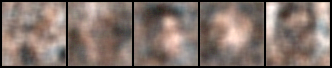

In [120]:
D_yn_img = (D_yn * 0.5 + 0.5).clamp(0, 1).cpu()
to_imgrid(D_yn_img, nrow=5)

In [128]:
adapt_denoiser = AdaptiveGaussianDenoiser(eigvec, eigval, patch_mean, P)

In [153]:
X_batch = Xtsr[5200:5400].cuda()
adapt_denoiser_wrapper = lambda x, sigma, cond=None: adapt_denoiser(x, sigma,)
with torch.no_grad():
    loss = edm_loss_fn(adapt_denoiser_wrapper, X_batch, )
    print(loss.mean().item())

0.27757662534713745


In [127]:
with torch.no_grad():
    loss = edm_loss_fn(model_precd, X_batch, )
    print(loss.mean().item())

0.6361628770828247


In [123]:
with torch.no_grad():
    loss = edm_loss_fn(model_precd, X_batch, )
    print(loss.mean().item())

0.7174425721168518
